In [2]:
import os
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from datetime import datetime, timedelta, date
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from utils import normalize_image, get_sequences, plot_image, plot_images
from dust_analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_root_dir = '/data2/jupiter/datasets'
unlabeled_datasets = ["halo_vehicles_driving_through_dust_images_nodust_reserved_stereo"]
labeled_datasets = ["halo_vehicles_driving_through_dust_images_nodust_reserved_labeled"]
pred_root_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
model = '20676_r2_rgb_bigdecay_biglr'

In [4]:
di = 0
raw_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[di], 'master_annotations.csv'))
raw_df['camera_pair'] = raw_df.unique_id.apply(lambda s: s[-7:])
stereo_df = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[di], 'master_annotations.csv'))
stereo_df['camera_pair'] = stereo_df.unique_id.apply(lambda s: s[-7:])
pred_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_datasets[di], 'output.csv'))
dust_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_datasets[di], 'dust_ratio.csv'))
print(raw_df.shape, stereo_df.shape, pred_df.shape, dust_df.shape)

(9630, 137) (4764, 238) (4764, 11) (4764, 7)


In [5]:
dust_df.head(2)

,unique_id,id,gt_dust_ratio,total_averaged_dust_conf,total_thresholded_dust_ratio,masked_avg_dust_conf,masked_dust_ratio
0,65e98b4a6af3b51a246857d2_T06_T07,65e98b4a6af3b51a246857d2,0.0,0.070795,0.033789,0.011985,0.0
1,65e98b89cafc4e811b02178e_T06_T07,65e98b89cafc4e811b02178e,0.0,0.054587,0.029883,0.009240,0.0


In [6]:
seq_dfs = get_sequences(stereo_df, interval=60, per_camera=False)
print(len(seq_dfs))

27


In [7]:
left_cameras = ['T01', 'T02', 'T05', 'T06', 'T09', 'T10', 'T13', 'T14', 'I01', 'I02']
camera_pairs = [['T01', 'T02'], ['T05', 'T06'], ['T09', 'T10'], ['T13', 'T14'], ['I01', 'I02']]
left_pass_pairs = ['T09_T11', 'T14_T16', 'T14_T15', 'T13_T15']
right_pass_pairs = ['T05_T07', 'T10_T12', 'T06_T08', 'T06_T07']

def read_raw_image(root_dir, dataset, row):
    return imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))

def read_rectified_image(root_dir, dataset, row):
    data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
    img = np.load(data_path)['left']
    return (normalize_image(img, True)*255).astype(np.uint8)

def add_text(frame, raw_row, pred_df, dust_df):
    frame = cv2.putText(frame, f'{raw_row.camera_pair}, {raw_row.collected_on}', 
                        (40,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    pred_rows = pred_df[pred_df.unique_id == raw_row.unique_id]
    if len(pred_rows) > 0:
        s = f'Pred state: {pred_rows.iloc[0].state}'
        frame = cv2.putText(frame, s, 
                            (40,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    dust_rows = dust_df[dust_df.unique_id == raw_row.unique_id]
    if len(dust_rows) > 0:
        s = f'Pred dust ratio: {dust_rows.iloc[0].total_averaged_dust_conf}'
        frame = cv2.putText(frame, s, 
                            (40,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    return frame

In [8]:
def create_video_from_rectified_rgb(seq_dfs, si, raw_df, pred_root_dir, model, labeled_datasets, di, data_root_dir, unlabeled_datasets, pred_df, dust_df):
    seq_df = seq_dfs[si]

    # get raw sequence
    start, end = seq_df.iloc[0].collected_on, seq_df.iloc[-1].collected_on
    seq_raw_df = raw_df[(raw_df.collected_on >= start) & (raw_df.collected_on <= end)]
    print(f'process {si}th sequence', seq_df.shape, seq_raw_df.shape)

    # get pair-wise cameras
    cameras = list(seq_df.camera_location.unique())
    cameras.sort()
    camera_pairs = list(seq_df.camera_pair.unique())
    camera_pairs.sort()
    print(cameras, camera_pairs)

    # check if should use left pass or right pass or both
    in_left = set(camera_pairs).intersection(left_pass_pairs)
    in_right = set(camera_pairs).intersection(right_pass_pairs)
    print(len(in_left), len(in_right))
    if len(in_left) > len(in_right):
        camera_pairs = left_pass_pairs
        pass_key = 'left_pass'
    elif len(in_left) < len(in_right):
        camera_pairs = right_pass_pairs
        pass_key = 'right_pass'
    else:
        pass_key = 'short_pass'

    # get per-camera dfs and truncate to same length
    camera_dfs = [seq_raw_df[seq_raw_df.unique_id.str.endswith(c)] for c in camera_pairs]
    camera_dfs = [cdf.sort_values('collected_on', ignore_index=True) for cdf in camera_dfs]
    min_len = min(len(cdf) for cdf in camera_dfs)
    camera_dfs = [cdf.iloc[:min_len] for cdf in camera_dfs]
    print([len(cdf) for cdf in camera_dfs])

    # create video
    video_dir = os.path.join(pred_root_dir, model, labeled_datasets[di], 'videos')
    os.makedirs(video_dir, exist_ok=True)
    video_name = os.path.join(video_dir, f'{start}_{pass_key}_{si}.mp4')
    height, width = 512, 768
    # print(width*2,height*math.ceil(len(camera_dfs)/2))

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 3, (width*2,height*math.ceil(len(camera_dfs)/2)), isColor=True)
    for fi in range(min_len):
        frames = []
        for pair_i in range(math.ceil(len(camera_dfs)/2)):
            pair_frame = []
            for _fi in range(2):
                if pair_i*2+_fi == len(camera_dfs):
                    frame = np.zeros((512, 768, 3), dtype=np.uint8)
                else:
                    frame = read_rectified_image(data_root_dir, unlabeled_datasets[di], camera_dfs[pair_i*2+_fi].iloc[fi])
                    if frame.shape[1] == 640:
                        zeros = np.zeros((512, 768, 3), dtype=frame.dtype)
                        zeros[:,:640,:] = frame
                        frame = zeros
                    frame = add_text(frame, camera_dfs[pair_i*2+_fi].iloc[fi], pred_df, dust_df)
                pair_frame.append(frame)
            pair_frame = np.concatenate(pair_frame, axis=1)
            frames.append(pair_frame)
        frame = np.concatenate(frames, axis=0)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video.write(frame)
    # cv2.destroyAllWindows()
    video.release()

for si in range(len(seq_dfs)):
    # si = 10
    create_video_from_rectified_rgb(seq_dfs, si, raw_df, pred_root_dir, model, labeled_datasets, di, data_root_dir, unlabeled_datasets, pred_df, dust_df)
    # break

process 0th sequence (154, 239) (232, 137)
['T09', 'T10', 'T13', 'T14'] ['T09_T11', 'T10_T11', 'T10_T12', 'T13_T15', 'T14_T15', 'T14_T16']
4 1
[38, 38, 38, 38]
process 1th sequence (158, 239) (223, 137)
['T09', 'T10', 'T13', 'T14'] ['T09_T11', 'T10_T11', 'T10_T12', 'T13_T15', 'T14_T15', 'T14_T16']
4 1
[37, 37, 37, 37]
process 2th sequence (150, 239) (262, 137)
['T05', 'T06', 'T09', 'T10'] ['T05_T07', 'T06_T07', 'T06_T08', 'T09_T11', 'T10_T11', 'T10_T12']
1 4
[42, 42, 42, 42]
process 3th sequence (157, 239) (282, 137)
['T05', 'T06', 'T09', 'T10'] ['T05_T07', 'T06_T07', 'T06_T08', 'T09_T11', 'T10_T11', 'T10_T12']
1 4
[46, 46, 46, 46]
process 4th sequence (93, 239) (177, 137)
['T05', 'T09', 'T10'] ['T05_T07', 'T09_T11', 'T10_T11', 'T10_T12']
1 2
[29, 29, 29, 29]
process 5th sequence (89, 239) (138, 137)
['T05', 'T06', 'T09', 'T10'] ['T05_T07', 'T06_T07', 'T06_T08', 'T09_T11', 'T10_T11', 'T10_T12']
1 4
[21, 21, 21, 21]
process 6th sequence (127, 239) (181, 137)
['T05', 'T06', 'T09', 'T10']

### Display images

In [47]:
# root_dir = '/data/jupiter/li.yu/data'
# root_dir = '/data/jupiter/datasets/'
root_dir = '/data2/jupiter/datasets/'
dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_stereo'
# dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_labeled'
csv = os.path.join(root_dir, dataset, 'master_annotations.csv.default')
# csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
# converters = {}
df = pd.read_csv(csv, converters=converters)
df.shape

(11139, 136)

In [36]:
# df['stereo_pipeline_npz_save_path'] = df['stereo_pipeline_npz_save_path'].apply(lambda s : s.replace('processed', 'processed.default'))
# df.to_csv(csv, index=False)

In [48]:
sub_df = df[(df.unique_id.str.endswith('T14_T15')) & (df.collected_on.str.startswith('2024-02-27T21:28:04.61'))]
# sub_df = df[(df.unique_id.str.endswith('T06_T07')) & (df.collected_on.str.startswith('2024-03-01T00:01:33.80'))]
print(sub_df.shape)

(1, 136)


/data2/jupiter/datasets/halo_vehicles_driving_through_dust_images_nodust_reserved_stereo/processed/images/65e9c91be879f487a28294f4/stereo_output_T14_T15.npz


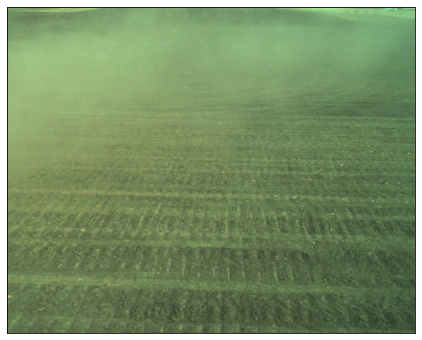

In [51]:
data_path = os.path.join(root_dir, dataset, sub_df.iloc[0].stereo_pipeline_npz_save_path)
data_path = data_path.replace('processed.default', 'processed')
print(data_path)
img = np.load(data_path)['left']
img_norm = normalize_image(img, True)
plot_image(img_norm)

65e9c91be879f487a28294f4 T14 2024-02-27T21:28:04.610000
/data2/jupiter/datasets/halo_vehicles_driving_through_dust_images_nodust_reserved_stereo/processed.default/images/65e9c91be879f487a28294f4/stereo_output_T14_T15.npz


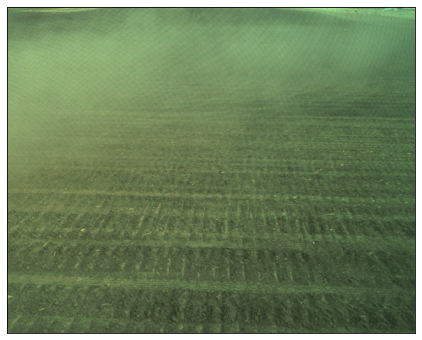

/data2/jupiter/datasets/halo_vehicles_driving_through_dust_images_nodust_reserved_stereo/images/65e9c91be879f487a28294f4/artifact_debayeredrgb_0_65e9c91be879f487a28294f4.png


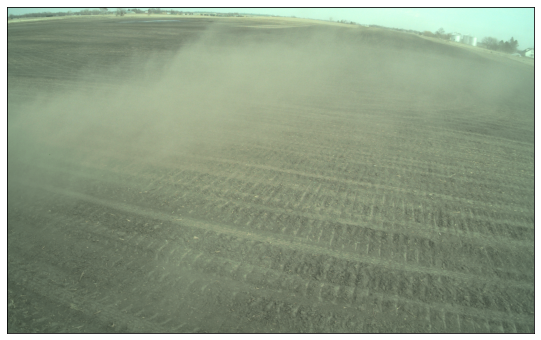

In [53]:
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['65e9b50a06198505e2a58145_T14_T15', '65e9beba4875033da619fb9b_T05_T07'])]
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
show_image, show_label = True, False
show_debayered_rgb, show_raw_label = True, False

for i, row in sub_df.iterrows():
    # print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf, row.total_thresholded_dust_ratio)
    print(row.id, row.camera_location, row.collected_on)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        print(data_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        print(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label == 25)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label == 25)

### plot gt dust vs. pre dust

In [ ]:
df2 = df.sort_values(by='gt_dust_ratio')
gt_ratios = df2.gt_dust_ratio.to_list()
pred_ratios = df2.total_thresholded_dust_ratio.to_list()

plt.figure(1, figsize=(12, 6))
plt.plot(range(len(gt_ratios)), gt_ratios, c='b', marker=".", label='gt dust level')
plt.scatter(range(len(gt_ratios)), pred_ratios, s=15, c='r', marker="o", label='pred dust level')
plot_human_state = False
if plot_human_state:
    tp_ids, fn_ids = [], []
    for i,row in df.iterrows():
        if row.state_y == 'true_positive':
            tp_ids.append(i)
        if row.state_y == 'false_negative':
            fn_ids.append(i)
    plt.scatter(tp_ids, [0.4] * len(tp_ids), s=20, c='g', marker="o", label='pred human TP')
    plt.scatter(fn_ids, [0.6] * len(fn_ids), s=20, c='purple', marker="o", label='pred human FN')
plt.legend(loc='upper left')
plt.ylim([-0.02, 1.0])
plt.xlabel('images in ascending gt dust level order')
plt.ylabel('dust level')
plt.show()